<a href="https://colab.research.google.com/github/srmp1382/projects_analysis_2025/blob/main/ibm_churn_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1362]:
import statsmodels, sklearn
from statsmodels.api import Logit, OLS
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report

In [1363]:
data=pd.read_excel('/content/sample_data/Telco_customer_churn.xlsx')

In [1364]:
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [1365]:
data.shape

(7043, 33)

In [1366]:
data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [1367]:
#Right away we see some columns that we can drop because they do not add any information:
#For example the count column has the same value of 1 for all the rows, so it is meaningless
#Similarly the country is United States for all the rows, so there is no variation and hence no information, so we can drop these right awa
#The customerID field is also not needed for prediction because it will not influence the churn value.
data['Count'].unique()

array([1])

In [1368]:
data['Country'].unique()

array(['United States'], dtype=object)

In [1369]:
data['State'].unique()

array(['California'], dtype=object)

In [1370]:
data['City'].nunique() #So this data is from 1129 cities

1129

In [1371]:
#(data.groupby("City")['Zip Code'].count()==5).sum()

In [1372]:
data.drop(['Count','Country','State','CustomerID'], axis=1, inplace=True)

In [1373]:
data.columns

Index(['City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [1374]:
#Now if we have city and zip code, then I will not need latitude and longitude for predicting churn.
#Also churn will not depend on the latitude or longitude, it depends on conditions like price or customer service.
#So I will drop the columns for latitude and longitude and the combination of both.
#For EDA I will keep the other columns, I will drop the city, state, gender, senior citizen, etc during prediction.

In [1375]:
data.drop(['Lat Long', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [1376]:
data.columns

Index(['City', 'Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [1377]:
data.isnull().sum()

,0
City,0
Zip Code,0
Gender,0
Senior Citizen,0
Partner,0
Dependents,0
Tenure Months,0
Phone Service,0
Multiple Lines,0
Internet Service,0


In [1378]:
#Here, I have 2 types of output that I can predict
#I have a churn score, which is out of 100, this is a continuous variable
#I also have a churn value or label, which is whether a customer has churned or not.
#So I can either use a regression to predict likelihood of churn, or I can predict whether he will churn or not and find a probability.

In [1379]:
#For this example now, I will predict whether the customer will churn or not using the value.
#I can also build a model using a linear or polynomial regression to find out which type of customer might give a higher churn score

In [1380]:
data.dtypes

,0
City,object
Zip Code,int64
Gender,object
Senior Citizen,object
Partner,object
Dependents,object
Tenure Months,int64
Phone Service,object
Multiple Lines,object
Internet Service,object


In [1381]:
data['Churn Label'].value_counts()

,count
Churn Label,
No,5174
Yes,1869


In [1382]:
data['Churn Value'].value_counts()

,count
Churn Value,
0,5174
1,1869


In [1383]:
#So 0 means not churned,1 is churned

In [1384]:
data['Gender'].value_counts()

,count
Gender,
Male,3555
Female,3488


In [1385]:
data['Partner'].value_counts()

,count
Partner,
No,3641
Yes,3402


In [1386]:
data['Dependents'].value_counts()

,count
Dependents,
No,5416
Yes,1627


In [1387]:
data['Senior Citizen'].value_counts()

,count
Senior Citizen,
No,5901
Yes,1142


In [1388]:
data['Contract'].value_counts()

,count
Contract,
Month-to-month,3875
Two year,1695
One year,1473


In [1389]:
(data['Total Charges']==' ').sum() #this shows there are spaces or blank values in the total charges column.
#I will drop these rows since I cannot assume that these people had zero charges.
#Or I can make it zero if I see that these people did not churn at all, having said that it will inject a little of my bias.
#Also since it is only 11 rows, it should not impact my data distribution

np.int64(11)

In [1390]:
data[data['Total Charges']== ' ']['Churn Label'].value_counts()

,count
Churn Label,
No,11


In [1391]:
data['Total Charges']=data['Total Charges'].replace(' ',0).astype(float)

/tmp/ipython-input-1677139480.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Total Charges']=data['Total Charges'].replace(' ',0).astype(float)


In [1392]:
data.dtypes

,0
City,object
Zip Code,int64
Gender,object
Senior Citizen,object
Partner,object
Dependents,object
Tenure Months,int64
Phone Service,object
Multiple Lines,object
Internet Service,object


<Axes: >

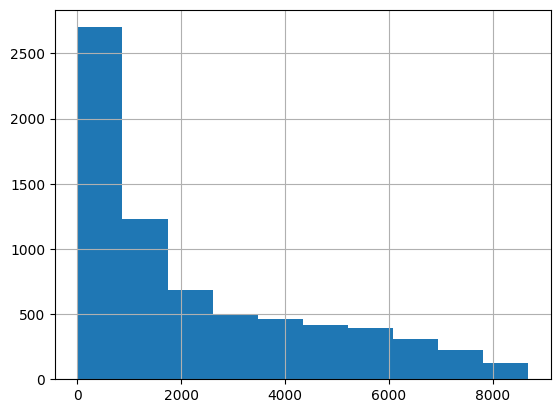

In [1393]:
data['Total Charges'].hist()

In [1394]:
#So most people pay very little for their services


<Axes: >

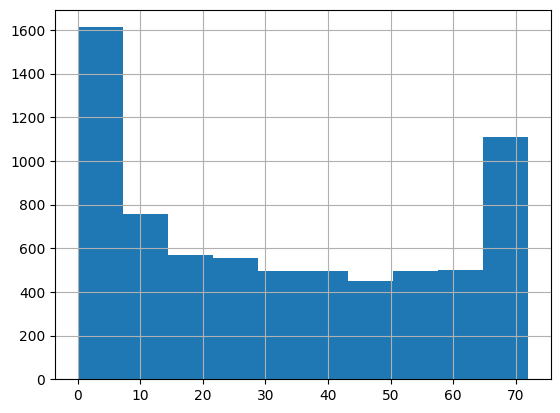

In [1395]:
data['Tenure Months'].hist()

In [1396]:
data['Streaming TV'].value_counts()

,count
Streaming TV,
No,2810
Yes,2707
No internet service,1526


In [1397]:
data['Streaming Movies'].value_counts()

,count
Streaming Movies,
No,2785
Yes,2732
No internet service,1526


In [1398]:
#This shows that around 50% of the people in the sample use streaming TV or movies or both.
#Given that the company does not charge for heavy bandwidth usage, this could impact other customers and their satisfaction, causing them to churn.

#Therefore my recommendation to the company is to charge for high bandwidth connections for heavy usage separately.
#This will allow the company to know whether this service is being used for free or if the user perceives enough value to pay for it.


In [1399]:
data['Phone Service'].value_counts()

,count
Phone Service,
Yes,6361
No,682


In [1400]:
data['Internet Service'].value_counts()

,count
Internet Service,
Fiber optic,3096
DSL,2421
No,1526


In [1401]:
data[['Phone Service','Internet Service']].value_counts()

Phone Service  Internet Service
Yes            Fiber optic         3096
               DSL                 1739
               No                  1526
No             DSL                  682
Name: count, dtype: int64

In [1402]:
data.groupby('Phone Service')['Total Charges'].mean()

,Total Charges
Phone Service,
No,1496.033651
Yes,2363.759432


In [1403]:
data.groupby('Internet Service')['Total Charges'].mean()

,Total Charges
Internet Service,
DSL,2115.411338
Fiber optic,3205.304570
No,662.604784


<Axes: >

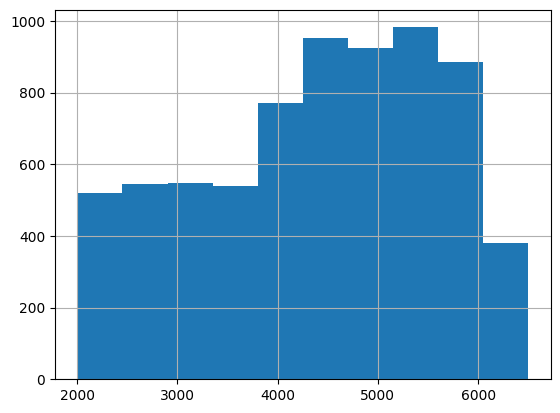

In [1404]:
data['CLTV'].hist()

In [1405]:
data['Total Charges'].corr(data['CLTV'])

np.float64(0.3420914675798509)

<Axes: >

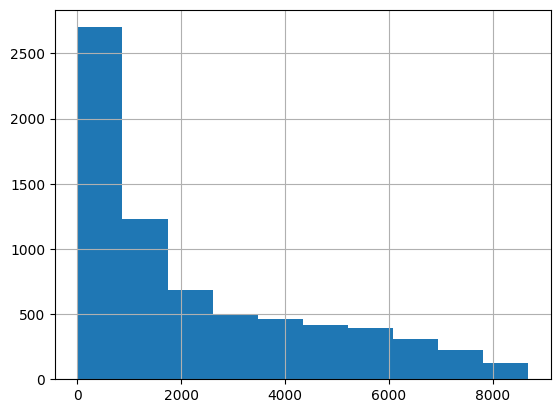

In [1406]:
data['Total Charges'].hist()

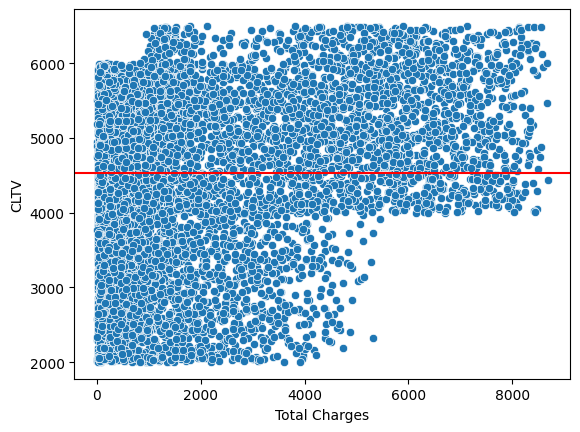

In [1407]:
sns.scatterplot(data, x='Total Charges',y='CLTV')
plt.axhline(data['CLTV'].median(), color='r')
#This shows that charges are not the only predictor for CLTV
#Or rather, high customer value has nothing to do with the customer paying high charges

<Axes: xlabel='Total Charges', ylabel='CLTV'>

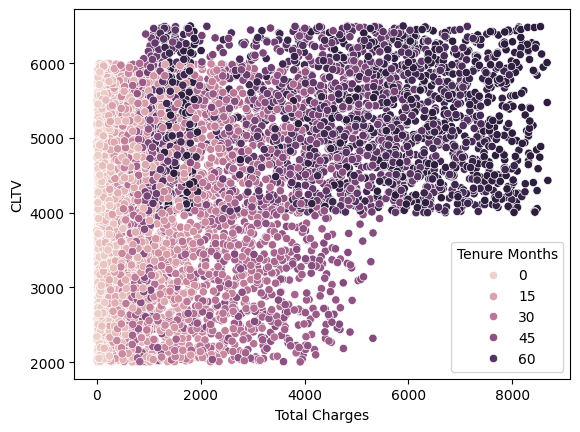

In [1408]:
sns.scatterplot(data, x='Total Charges', y='CLTV', hue='Tenure Months')

<Axes: xlabel='Total Charges', ylabel='CLTV'>

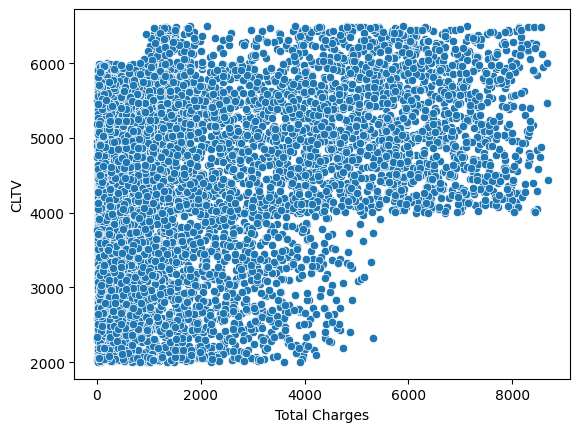

In [1409]:
sns.scatterplot(data, x='Total Charges', y='CLTV')

<Axes: >

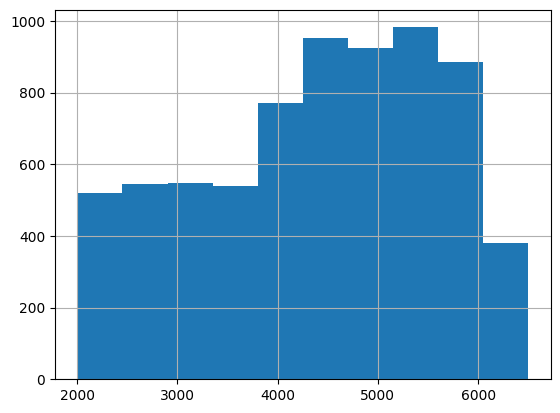

In [1410]:
data['CLTV'].hist()

In [1411]:
high_val_cust=data[data['CLTV']>4000]

<Axes: xlabel='Contract', ylabel='CLTV'>

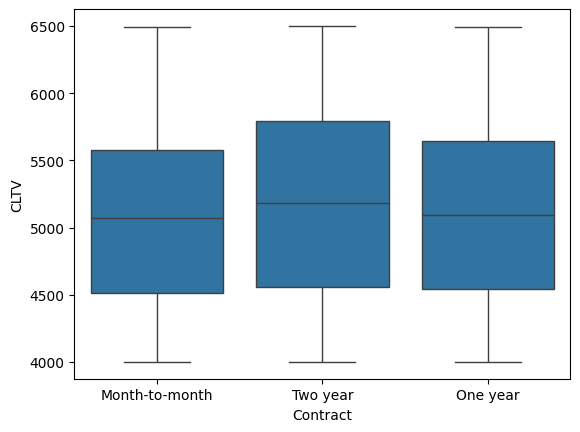

In [1412]:
sns.boxplot(high_val_cust,x='Contract', y='CLTV')

<Axes: xlabel='Tech Support', ylabel='CLTV'>

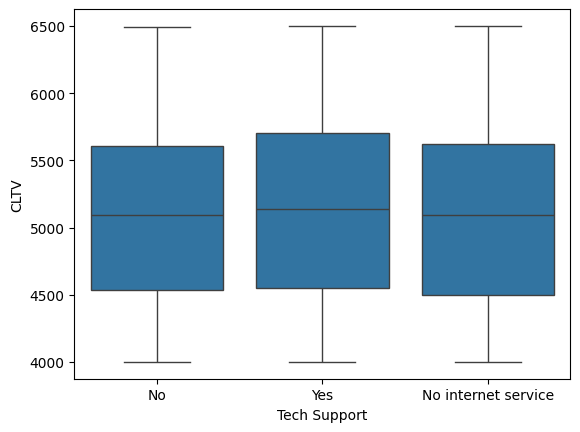

In [1413]:
sns.boxplot(high_val_cust, x='Tech Support', y='CLTV')

<Axes: >

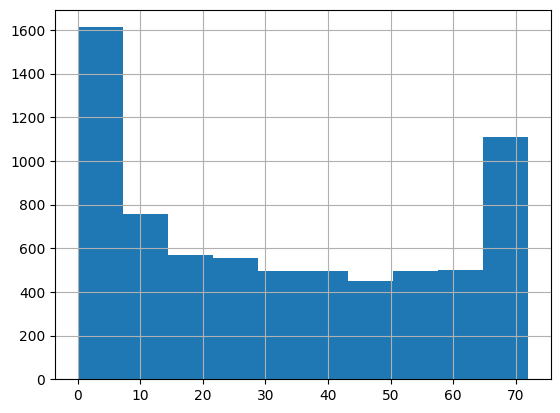

In [1414]:
data['Tenure Months'].hist()

<Axes: xlabel='Tenure Months', ylabel='CLTV'>

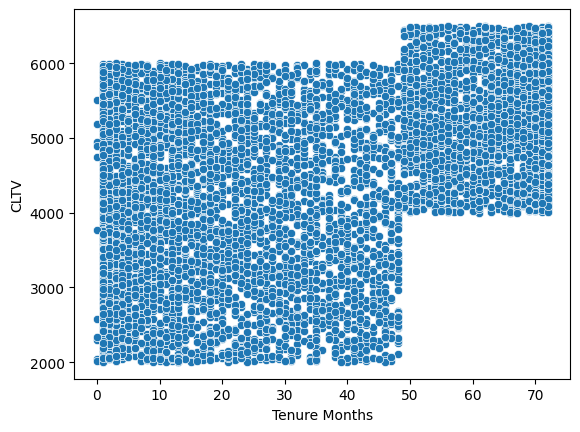

In [1415]:
sns.scatterplot(data, x='Tenure Months', y='CLTV') #clearly Tenure affects CLTV positively

<Axes: xlabel='Tenure Months', ylabel='Total Charges'>

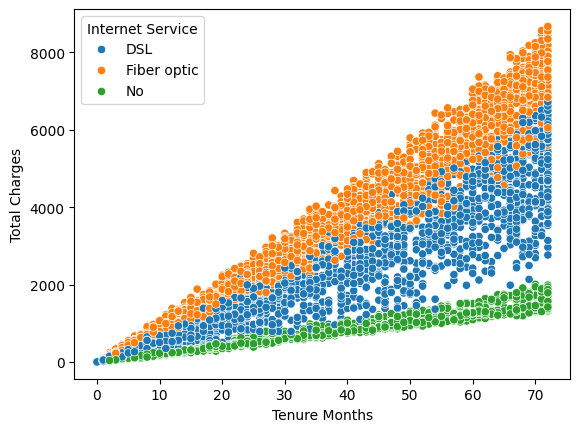

In [1416]:
sns.scatterplot(data, x='Tenure Months', y='Total Charges', hue='Internet Service')

In [1417]:
data['High Val Customer']=np.where(data['CLTV']>=4000,'Yes','No')

In [1418]:
data

,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,High Val Customer
0,Los Angeles,90003,Male,No,No,No,2,Yes,No,DSL,...,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,No
1,Los Angeles,90005,Female,No,No,Yes,2,Yes,No,Fiber optic,...,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,No
2,Los Angeles,90006,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved,Yes
3,Los Angeles,90010,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,Yes
4,Los Angeles,90015,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,Female,No,No,No,72,Yes,No,No,...,Yes,Bank transfer (automatic),21.15,1419.40,No,0,45,5306,NaN,Yes
7039,Adelanto,92301,Male,No,Yes,Yes,24,Yes,Yes,DSL,...,Yes,Mailed check,84.80,1990.50,No,0,59,2140,NaN,No
7040,Amboy,92304,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,...,Yes,Credit card (automatic),103.20,7362.90,No,0,71,5560,NaN,Yes
7041,Angelus Oaks,92305,Female,No,Yes,Yes,11,No,No phone service,DSL,...,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN,No


In [1419]:
data.loc[data['Tenure Months']>=50,"Long term customer"]="Yes"

In [1420]:
data.loc[data['Tenure Months']<50, "Long term customer"]="No"

<Axes: xlabel='Long term customer', ylabel='CLTV'>

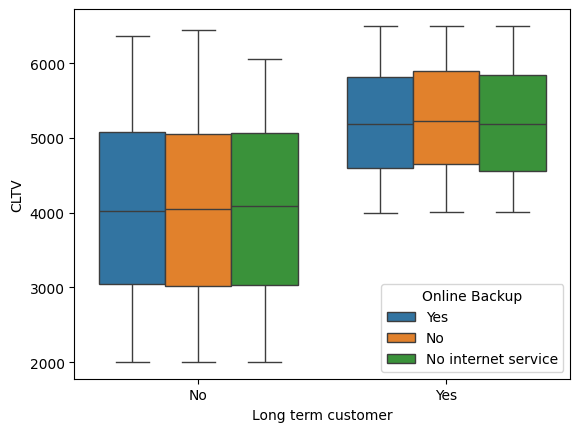

In [1421]:
sns.boxplot(data, x='Long term customer', y='CLTV', hue='Online Backup')

<Axes: xlabel='Long term customer', ylabel='CLTV'>

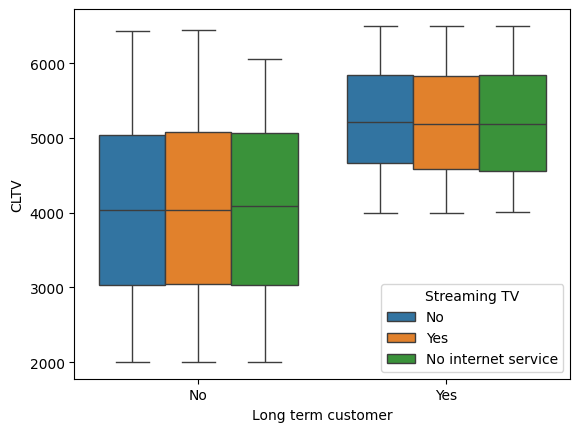

In [1422]:
sns.boxplot(data,x='Long term customer', y='CLTV', hue='Streaming TV')

<Axes: xlabel='Long term customer', ylabel='CLTV'>

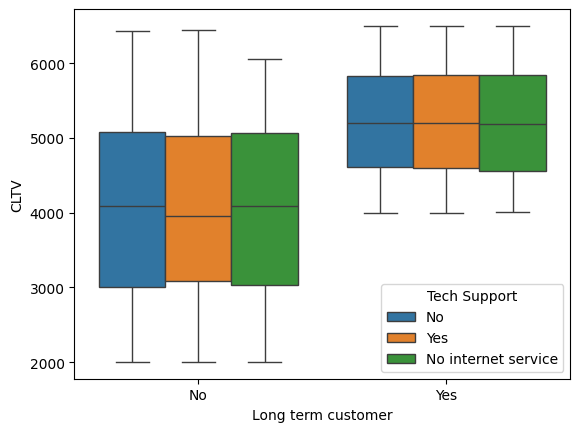

In [1423]:
sns.boxplot(data, x='Long term customer', y='CLTV', hue='Tech Support')

In [1424]:
# I tried and found that there is some missing feature that is not provided here that differentiates a high value customer from an ordinary customer.
# My recommendation to the company is to go back and explore and collect more features which will tell us what causes a customer to add more value.
# Clearly spending is not related directly to value, and time is a factor which matters.

<Axes: xlabel='Streaming Movies', ylabel='Tenure Months'>

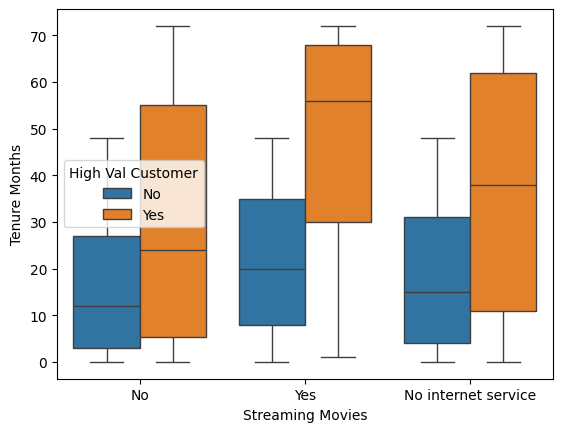

In [1425]:
sns.boxplot(data, y='Tenure Months', x='Streaming Movies', hue='High Val Customer')

In [1426]:
#This shows that the long term customers use services like streaming movies
#It also shows that there are customers who are long term and they dont take any internet.
#This means that the company can identify such customers and encourage them to use other services instead of internet and pay for them.

In [1427]:
data['High spender']=np.where(data['Total Charges']>=5000,"Yes","No")

<Axes: xlabel='Long term customer', ylabel='CLTV'>

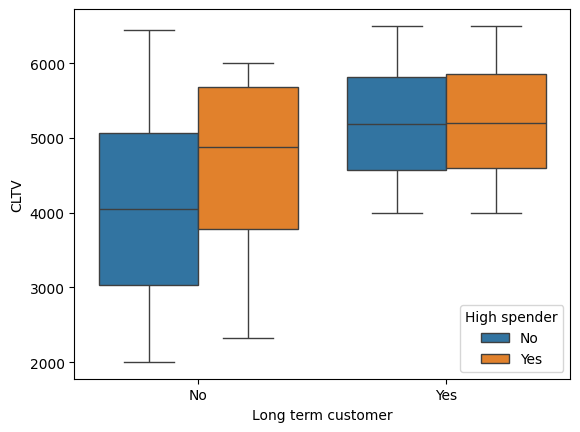

In [1428]:
sns.boxplot(data, x='Long term customer', y='CLTV', hue='High spender')
#This shows that for customers who have spent more time being with the company, their spending does not increase the CLTV.
#So providing extra services to maybe newer customers is better, long term customers need something more.


<Axes: xlabel='High spender', ylabel='CLTV'>

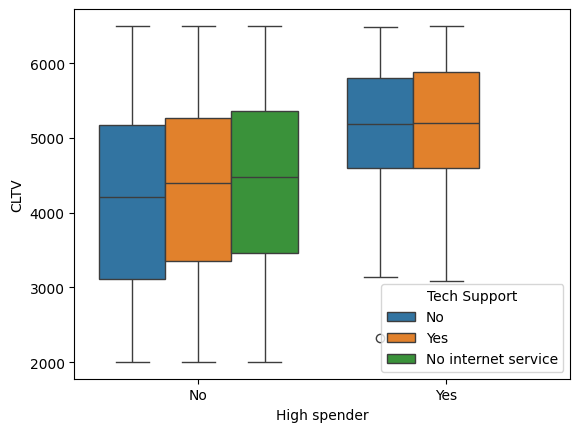

In [1429]:
sns.boxplot(data, x='High spender', y='CLTV', hue='Tech Support')

<Axes: xlabel='High spender', ylabel='CLTV'>

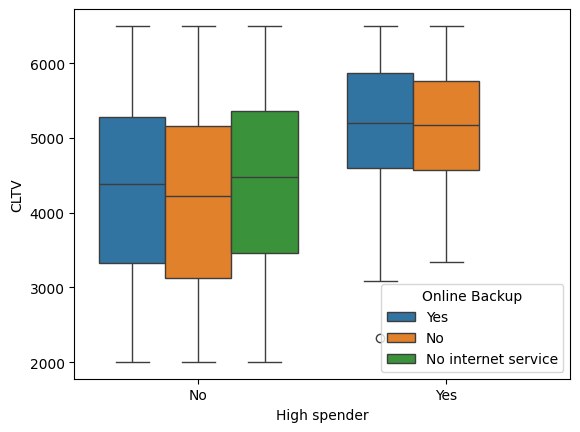

In [1430]:
sns.boxplot(data, x='High spender', y='CLTV', hue='Online Backup')

<Axes: xlabel='Online Backup', ylabel='Total Charges'>

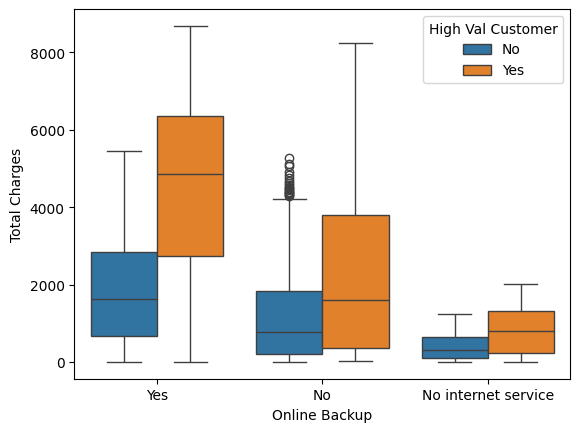

In [1431]:
sns.boxplot(data, x='Online Backup', y='Total Charges', hue='High Val Customer')

<Axes: xlabel='Tech Support', ylabel='Total Charges'>

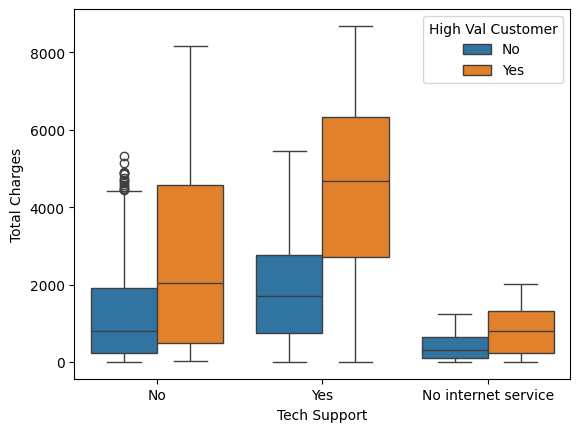

In [1432]:
sns.boxplot(data, x='Tech Support', y='Total Charges', hue='High Val Customer')

<Axes: xlabel='High Val Customer', ylabel='Total Charges'>

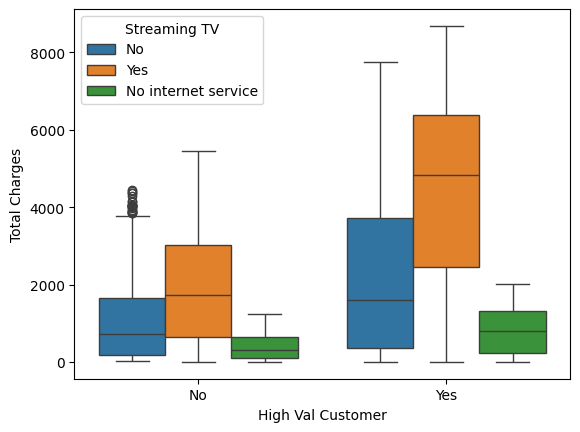

In [1433]:
sns.boxplot(data, hue='Streaming TV', y='Total Charges', x='High Val Customer')

In [1434]:
#We see that high value customers spend a lot more on tech support and online backups as well as other services.

<Axes: xlabel='High Val Customer', ylabel='count'>

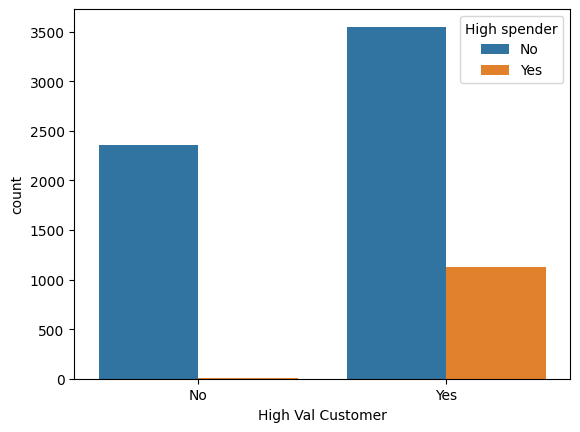

In [1435]:
sns.countplot(data, hue='High spender', x='High Val Customer')

In [1436]:
#This clearly shows that customers who are long term and high value spend more, however most of the high value customers are not high spending
# So it is important to find what makes contributes to the CLTV, something like frequency, even though the monthly spending may not be so high.

In [1437]:
#Now to see how all this impacts the churn

In [1438]:
data.groupby('Churn Label')['High Val Customer'].value_counts()*100/data.groupby('Churn Label')['Churn Label'].count()

Churn Label  High Val Customer
No           Yes                  69.945883
             No                   30.054117
Yes          Yes                  56.554307
             No                   43.445693
dtype: float64

In [1439]:
#The above table crearly shows that among the people who churned, 56% were high value customers

In [1440]:
data.groupby('High Val Customer')['Churn Label'].value_counts()*100/data.groupby('High Val Customer')['Churn Label'].count()

High Val Customer  Churn Label
No                 No             65.694973
                   Yes            34.305027
Yes                No             77.395210
                   Yes            22.604790
dtype: float64

In [1441]:
#Here we see that only only 22% of high value customers churned against 34% of others

In [1442]:
data.groupby('High spender')['Churn Label'].value_counts()*100/data.groupby('High spender')['Churn Label'].count()

High spender  Churn Label
No            No             71.022343
              Yes            28.977657
Yes           No             86.167401
              Yes            13.832599
dtype: float64

In [1443]:
data.groupby(['High Val Customer','High spender'])['Churn Label'].value_counts()*100/data.groupby(['High Val Customer','High spender'])['Churn Label'].count()

High Val Customer  High spender  Churn Label
No                 No            No             65.634281
                                 Yes            34.365719
                   Yes           No             80.000000
                                 Yes            20.000000
Yes                No            No             74.598705
                                 Yes            25.401295
                   Yes           No             86.222222
                                 Yes            13.777778
dtype: float64

In [1444]:
#so the churn is loest among high value customers who also spend more

In [1445]:
data.groupby(['High Val Customer','Long term customer'])['Churn Label'].value_counts()*100/data.groupby(['High Val Customer','Long term customer'])['Churn Label'].count()

High Val Customer  Long term customer  Churn Label
No                 No                  No             65.694973
                                       Yes            34.305027
Yes                No                  No             65.681183
                                       Yes            34.318817
                   Yes                 No             90.888173
                                       Yes             9.111827
dtype: float64

In [1446]:
#This shows tat high value customers are likely to churn when they have not yet spent more than 50 months with the company.
#So the company needs to focus on this group, once they become long term, their churn rate dropped from 34% to 9%.

In [1447]:
data.groupby(['High Val Customer','Long term customer', 'High spender'])['Churn Label'].value_counts()*100/data.groupby(['High Val Customer','Long term customer','High spender'])['Churn Label'].count()

High Val Customer  Long term customer  High spender  Churn Label
No                 No                  No            No             65.634281
                                                     Yes            34.365719
                                       Yes           No             80.000000
                                                     Yes            20.000000
Yes                No                  No            No             65.808528
                                                     Yes            34.191472
                                       Yes           Yes            52.941176
                                                     No             47.058824
                   Yes                 No            No             95.117371
                                                     Yes             4.882629
                                       Yes           No             86.823105
                                                     Yes            13.176895
dtype: float64

In [1448]:
#this clearly shows that high spending does reduce the risk of churn
#however the best group are the people who have nothing to do with high spending yet are high value and long term customers.
#So the company should identify what makes them so special, because it is clear that extra services do not make a difference to this group

<Axes: xlabel='Contract', ylabel='count'>

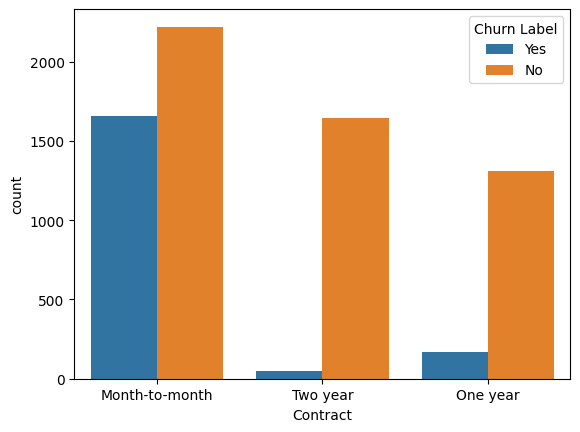

In [1449]:
sns.countplot(data, hue='Churn Label', x='Contract')

In [1450]:
#This graph shows that people who have a longer contract churn less, customers on a monthly contract churn more

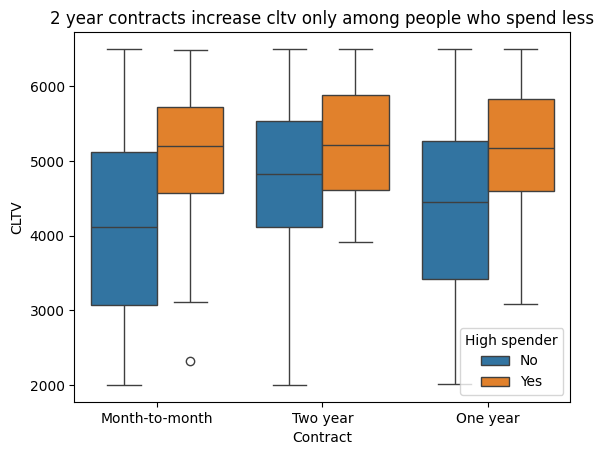

In [1520]:
sns.boxplot(data, x='Contract', y='CLTV', hue='High spender')
plt.title('2 year contracts increase cltv only among people who spend less')
plt.show()

In [1521]:
#This graph above shows that customers who have a long term contract have a higher CLTV
#However high spenders have the same CLTV across contract types
#So my recommendation is to identify people who are not high spenders and switch them to the 2 year contract by making it cheaper.

<Axes: xlabel='Tenure Months', ylabel='CLTV'>

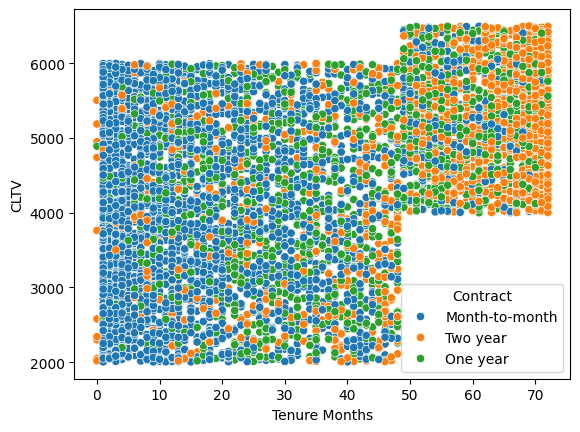

In [1522]:
sns.scatterplot(data, x='Tenure Months', y='CLTV',hue='Contract')

In [1523]:
#Most of the people who are adding more value are also having a 2 year contract

In [1524]:
data.groupby(['High Val Customer','Contract'])['Churn Label'].value_counts()*100/data.groupby(['High Val Customer','Contract'])['Churn Label'].count()

High Val Customer  Contract        Churn Label
No                 Month-to-month  No             55.691057
                                   Yes            44.308943
                   One year        No             88.725490
                                   Yes            11.274510
                   Two year        No             98.734177
                                   Yes             1.265823
Yes                Month-to-month  No             58.569438
                                   Yes            41.430562
                   One year        No             88.732394
                                   Yes            11.267606
                   Two year        No             96.913580
                                   Yes             3.086420
dtype: float64

In [1525]:
#Clearly, having a 2 year contract has reduced the rate of churn.
#Hence my recommendation is that the company make the 2 year contract cheaper so that more people will move to that and it will reduce churn

In [1526]:
data.columns

Index(['City', 'Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason',
       'High Val Customer', 'Long term customer', 'High spender'],
      dtype='object')

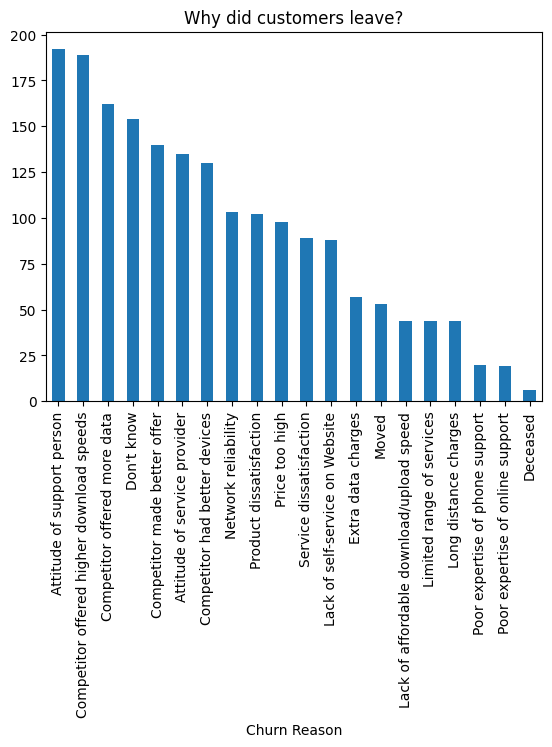

In [1527]:
data[data['Churn Label']=='Yes']['Churn Reason'].value_counts().plot(kind='bar')
plt.title('Why did customers leave?')
plt.show()

In [1528]:
#This shows what the theory supports: That people leave because they have a bad experience with the service and is usability.
#The primary reason that customers leave is not because of price, it is because of the attitude of the service provider
#Hence we can suggest that the telecom company invest in customer service trainings and simplify their portal design to include self service.
#This will help them reduce their churn significantly.

In [1529]:
#We eliminate all the demographic factors because these will have nothing to do with churn, there is no cause and effect

In [1530]:
x_clf=data.drop(['Churn Value','Churn Label','Gender','Churn Score','City','Zip Code','Partner','Dependents','Payment Method','Monthly Charges', 'Paperless Billing','Churn Reason'], axis=1)

In [1531]:
y_clf=data['Churn Value']

In [1532]:
x_clf.dtypes

,0
Senior Citizen,object
Tenure Months,int64
Phone Service,object
Multiple Lines,object
Internet Service,object
Online Security,object
Online Backup,object
Device Protection,object
Tech Support,object
Streaming TV,object


In [1533]:
#I am now dropping the older features in favour of the newer ones I created
#I could have done a t test just to verify that my new features predict better

In [1534]:
x_clf=x_clf.drop(['Tenure Months','Total Charges','CLTV'], axis=1)

In [1535]:
x_clf.dtypes

,0
Senior Citizen,object
Phone Service,object
Multiple Lines,object
Internet Service,object
Online Security,object
Online Backup,object
Device Protection,object
Tech Support,object
Streaming TV,object
Streaming Movies,object


In [1536]:
#Now that everything is categorical, I will do a one hot encoding
x_clf=pd.get_dummies(x_clf, drop_first=True) #I just replaced it because everything is categorical

In [1537]:
x_clf.columns

Index(['Senior Citizen_Yes', 'Phone Service_Yes',
       'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No internet service', 'Tech Support_Yes',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No internet service', 'Streaming Movies_Yes',
       'Contract_One year', 'Contract_Two year', 'High Val Customer_Yes',
       'Long term customer_Yes', 'High spender_Yes'],
      dtype='object')

In [1538]:
x_clf.shape

(7043, 23)

In [1539]:
y_clf.shape

(7043,)

In [1540]:
xtrain, xtest, ytrain, ytest=train_test_split(x_clf, y_clf, test_size=0.2, random_state=10)

In [1541]:
model_logit=Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.430537
         Iterations 8


In [1542]:
model_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Churn Value   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5617
Method:                           MLE   Df Model:                           16
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.2547
Time:                        06:41:51   Log-Likelihood:                -2425.6
converged:                       True   LL-Null:                       -3254.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Senior Citizen_Yes                        0.1627      0.091      1.792      0.073      -0.015       0.341
Phone Service_Yes                        -0.5413      0.104     -5.221      0.000      -0.744      -0.338
Multiple Lines_No phone service          -0.0387      0.129     -0.301      0.764      -0.291       0.214
Multiple Lines_Yes                        0.0269      0.083      0.322      0.747      -0.137       0.190
Internet Service_Fiber optic              0.9075      0.100      9.079      0.000       0.712       1.103
Internet Service_No                      -0.1594        nan        nan        nan         nan         nan
Online Security_No internet service      -0.1594        nan        nan        nan         nan         nan
Online Security_Yes                      -0.5817      0.092     -6.320      0.000      -0.762      -0.401
Online Backup_No internet service        -0.1594        nan        nan        nan         nan         nan
Online Backup_Yes                        -0.3490      0.082     -4.244      0.000      -0.510      -0.188
Device Protection_No internet service    -0.1594        nan        nan        nan         nan         nan
Device Protection_Yes                    -0.2045      0.084     -2.427      0.015      -0.370      -0.039
Tech Support_No internet service         -0.1594        nan        nan        nan         nan         nan
Tech Support_Yes                         -0.4518      0.094     -4.819      0.000      -0.636      -0.268
Streaming TV_No internet service         -0.1594        nan        nan        nan         nan         nan
Streaming TV_Yes                          0.2242      0.086      2.616      0.009       0.056       0.392
Streaming Movies_No internet service     -0.1594        nan        nan        nan         nan         nan
Streaming Movies_Yes                      0.2467      0.086      2.873      0.004       0.078       0.415
Contract_One year                        -1.2155      0.114    -10.683      0.000      -1.439      -0.993
Contract_Two year                        -2.0912      0.193    -10.827      0.000      -2.470      -1.713
High Val Customer_Yes                    -0.0483      0.077     -0.631      0.528      -0.198       0.102
Long term customer_Yes                   -0.9867      0.184     -5.375      0.000      -1.346      -0.627
High spender_Yes                          0.5080      0.206      2.462      0.014       0.104       0.912
=========================================================================================================
"""

In [1543]:
#We see above that all features are not significant, I will use significant features only in the next part

In [1544]:
ypred=model_logit.predict(xtest) #Using all the features

In [1545]:
thresh=0.5
ypred_bin=[1 if i>=thresh else 0 for i in ypred]

In [1546]:
print(classification_report(ytest, ypred_bin))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1030
           1       0.60      0.51      0.55       379

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [1547]:
#In our case, predicting who will churn correctly is more important than predicting who will not churn
#Hence I will want to maximize my recall of class 1
#So I will reduce the threshold

In [1548]:
thresh=0.2
ypred_bin=[1 if i>=thresh else 0 for i in ypred]

In [1549]:
print(classification_report(ytest, ypred_bin))

              precision    recall  f1-score   support

           0       0.91      0.64      0.76      1030
           1       0.46      0.84      0.60       379

    accuracy                           0.70      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.70      0.71      1409



In [1550]:
#reducing the recall further will be better so I will lower the threshold further
thresh=0.009
ypred_bin=[1 if i>=thresh else 0 for i in ypred]

In [1551]:
print(classification_report(ytest, ypred_bin))

              precision    recall  f1-score   support

           0       0.99      0.07      0.13      1030
           1       0.28      1.00      0.44       379

    accuracy                           0.32      1409
   macro avg       0.63      0.53      0.29      1409
weighted avg       0.80      0.32      0.22      1409



In [1552]:
#Now I am able to correctly predict customers who are likely to churn

In [1553]:
#using only significant features

In [1554]:
xtrain_new=xtrain[model_logit.pvalues[model_logit.pvalues<0.05].index]
xtest_new=xtest[model_logit.pvalues[model_logit.pvalues<0.05].index]

In [1555]:
model_logit_new=Logit(ytrain, xtrain_new).fit()

Optimization terminated successfully.
         Current function value: 0.436479
         Iterations 8


In [1556]:
model_logit_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Churn Value   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5622
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.2444
Time:                        06:41:55   Log-Likelihood:                -2459.1
converged:                       True   LL-Null:                       -3254.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Phone Service_Yes               -1.0337      0.069    -14.908      0.000      -1.170      -0.898
Internet Service_Fiber optic     1.3217      0.089     14.914      0.000       1.148       1.495
Online Security_Yes             -0.4750      0.091     -5.218      0.000      -0.653      -0.297
Online Backup_Yes               -0.2703      0.082     -3.316      0.001      -0.430      -0.111
Device Protection_Yes           -0.1455      0.084     -1.726      0.084      -0.311       0.020
Tech Support_Yes                -0.3526      0.093     -3.784      0.000      -0.535      -0.170
Streaming TV_Yes                 0.2710      0.086      3.157      0.002       0.103       0.439
Streaming Movies_Yes             0.2974      0.086      3.475      0.001       0.130       0.465
Contract_One year               -1.3540      0.111    -12.163      0.000      -1.572      -1.136
Contract_Two year               -2.3492      0.188    -12.517      0.000      -2.717      -1.981
Long term customer_Yes          -1.0113      0.178     -5.696      0.000      -1.359      -0.663
High spender_Yes                 0.4945      0.202      2.452      0.014       0.099       0.890
================================================================================================
"""

In [1557]:
ypred_new=model_logit_new.predict(xtest_new)

In [1558]:
thresh_new=0.5
ypred_bin_new=[1 if i>=thresh_new else 0 for i in ypred_new]

In [1559]:
print(classification_report(ytest, ypred_bin_new))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1030
           1       0.57      0.54      0.56       379

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.77      0.77      1409



In [1560]:
#using only significant features improves both the recall, it went up from 51% to 54% by using fewer features

In [1561]:
#Now using a random forest classifier to see if it can fit better

In [1562]:
model_rf=RandomForestClassifier()

In [1563]:
model_rf.fit(xtrain_new, ytrain)

RandomForestClassifier()

In [1564]:
ypred_rf=model_rf.predict(xtest_new)

In [1565]:
print(classification_report(ytest, ypred_rf))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1030
           1       0.55      0.48      0.52       379

    accuracy                           0.76      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.76      0.75      1409



In [1566]:
#so we see here that sometimes a simple model can sometimes lead to a better classification, compared to more advanced models

In [1567]:
#Now trying regression

In [1568]:
y_new=data['Churn Score'] #This is a continuous variable so I will use OLS regression,  I can also use sklearn if needed

In [1569]:
xtrain_reg, xtest_reg, ytrain_reg, ytest_reg=train_test_split(x_clf, y_new, test_size=0.2, random_state=10)

In [1570]:
model_reg=OLS(ytrain_reg, xtrain_reg).fit()

In [1571]:
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Churn Score   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     46.52
Date:                Sun, 26 Oct 2025   Prob (F-statistic):          1.40e-138
Time:                        06:42:02   Log-Likelihood:                -24934.
No. Observations:                5634   AIC:                         4.990e+04
Df Residuals:                    5617   BIC:                         5.001e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Senior Citizen_Yes                        1.1422      0.778      1.468      0.142      -0.383       2.667
Phone Service_Yes                        62.2374      0.872     71.407      0.000      60.529      63.946
Multiple Lines_No phone service          63.9818      1.099     58.219      0.000      61.827      66.136
Multiple Lines_Yes                        1.2241      0.641      1.910      0.056      -0.033       2.481
Internet Service_Fiber optic              5.4685      0.777      7.036      0.000       3.945       6.992
Internet Service_No                      -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Online Security_No internet service      -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Online Security_Yes                      -3.3715      0.708     -4.763      0.000      -4.759      -1.984
Online Backup_No internet service        -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Online Backup_Yes                        -1.7502      0.669     -2.617      0.009      -3.061      -0.439
Device Protection_No internet service    -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Device Protection_Yes                    -2.1117      0.691     -3.056      0.002      -3.466      -0.757
Tech Support_No internet service         -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Tech Support_Yes                         -1.8438      0.727     -2.535      0.011      -3.270      -0.418
Streaming TV_No internet service         -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Streaming TV_Yes                          0.8062      0.709      1.137      0.256      -0.584       2.196
Streaming Movies_No internet service     -0.7699      0.150     -5.133      0.000      -1.064      -0.476
Streaming Movies_Yes                      2.2620      0.709      3.189      0.001       0.871       3.653
Contract_One year                        -6.0453      0.791     -7.645      0.000      -7.595      -4.495
Contract_Two year                        -6.1268      0.946     -6.478      0.000      -7.981      -4.273
High Val Customer_Yes                    -0.4549      0.650     -0.700      0.484      -1.728       0.819
Long term customer_Yes                   -2.3023      0.955     -2.412      0.016      -4.174      -0.431
High spender_Yes                         -1.5330      1.129     -1.357      0.175      -3.747       0.681
==============================================================================
Omnibus:                      568.251   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.091
Skew:                          -0.227   Prob(JB):                     1.77e-45
Kurtosis:  

In [1572]:
ypred_reg=model_reg.predict(xtest_reg)

In [1573]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [1574]:
print(mean_squared_error(ytest_reg, ypred_reg))

425.00250289438605


In [1575]:
#If I take only significant features

In [1576]:
xtrain_reg_new=xtrain_reg[model_reg.pvalues[model_reg.pvalues<0.05].index]
xtest_reg_new=xtest_reg[model_reg.pvalues[model_reg.pvalues<0.05].index]

In [1577]:
model_reg_new=OLS(ytrain_reg, xtrain_reg_new).fit()

In [1578]:
model_reg_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Churn Score   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     66.77
Date:                Sun, 26 Oct 2025   Prob (F-statistic):          4.97e-141
Time:                        06:42:05   Log-Likelihood:                -24939.
No. Observations:                5634   AIC:                         4.990e+04
Df Residuals:                    5622   BIC:                         4.998e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Phone Service_Yes                        62.8222      0.747     84.093      0.000      61.358      64.287
Multiple Lines_No phone service          64.3252      0.976     65.888      0.000      62.411      66.239
Internet Service_Fiber optic              5.7364      0.735      7.808      0.000       4.296       7.177
Internet Service_No                      -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Online Security_No internet service      -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Online Security_Yes                      -3.5562      0.703     -5.057      0.000      -4.935      -2.178
Online Backup_No internet service        -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Online Backup_Yes                        -1.7587      0.660     -2.666      0.008      -3.052      -0.465
Device Protection_No internet service    -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Device Protection_Yes                    -2.0592      0.681     -3.024      0.003      -3.394      -0.724
Tech Support_No internet service         -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Tech Support_Yes                         -1.9783      0.720     -2.748      0.006      -3.390      -0.567
Streaming TV_No internet service         -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Streaming Movies_No internet service     -0.8353      0.148     -5.643      0.000      -1.125      -0.545
Streaming Movies_Yes                      2.5201      0.665      3.791      0.000       1.217       3.823
Contract_One year                        -6.0832      0.789     -7.711      0.000      -7.630      -4.537
Contract_Two year                        -6.0673      0.941     -6.445      0.000      -7.913      -4.222
Long term customer_Yes                   -2.7862      0.776     -3.589      0.000      -4.308      -1.264
==============================================================================
Omnibus:                      577.943   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.077
Skew:                          -0.229   Prob(JB):                     6.56e-46
Kurtosis:                       2.177   Cond. No.                     3.27e+32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-61. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1579]:
#by looking at the coefficients, we see that the most important features are whether the customer has a phone line, and if he has multiple lines
#However as we saw in the EDA above, this could be misleading

In [1580]:
ypred_reg_new=model_reg_new.predict(xtest_reg_new)

In [1581]:
ypred_reg_new.describe()

,0
count,1409.000000
mean,58.824603
std,7.306503
min,44.600469
25%,51.681287
50%,58.407306
75%,65.086679
max,71.078705


In [1582]:
#Now I can assign a label to this by puttting the following, and then put it in the dataframe column so we can use it directly
# anything below a score of 50 as very likely to churn,
# 50-65 moderately likely to churn
# >65 highly likely to churn

In [1583]:
ypred_churn_likely=["High" if i>=65 else "Moderate" if i in range(50,65) else "Low" for i in ypred_reg_new]

In [1584]:
xtest_reg['Likely to churn']=ypred_churn_likely

In [1585]:
xtest_reg

,Senior Citizen_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,High Val Customer_Yes,Long term customer_Yes,High spender_Yes,Likely to churn
6418,False,False,True,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,False,False,Low
1948,True,False,True,False,False,False,False,False,False,True,...,False,True,False,False,True,False,True,True,False,Low
4497,True,False,True,False,False,False,False,True,False,True,...,False,True,False,True,False,False,False,False,False,Low
66,True,True,False,False,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,High
1705,False,True,False,False,True,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,Low
5938,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,High
6373,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,True,False,False,Low
1767,False,True,False,False,True,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,Low


In [1586]:
print(mean_squared_error(ytest_reg, ypred_reg_new))

426.4435951418348


In [1587]:
#Conclusions:
#1. Our goal is to which customers would churn correctly, and for that I increased recall by lowering the threshold
#2. We see that customers having a 2 year contract, the churn is less.
#We also understand that this is more in people who are not high spenders
#Hence the suggestion is that the company offer customers to either buy a long contract or spend more in other ways.
#3. Higher spending causes more value, and long term customers also add more value.
#I suggest that the company charge for its value added services at a nominal rate, since it will help them identify whether the service adds value.
